<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/s2_env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 这个就是drive里面的文件路径
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

BoroughShp  GreatLondonShp  s1	s2_Env	s3


## 基础导入啥的

In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree

## 1.gvi

In [4]:
boroughs_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/BoroughShp/borough.shp")
print(boroughs_gdf.columns)

edges_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/s1/Roads_OT/CQI_final/s1merge.gpkg")
print(edges_gdf.columns)

gvi_points = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/greenview_london.json/greenview_london.json")
print(gvi_points.columns)

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry'],
      dtype='object')
Index(['id', 'name', 'way_type', 'index', 'index_10', 'stress_level', 'offset',
       'side', 'proc_width', 'proc_surface', 'proc_smoothness', 'proc_oneway',
       'proc_sidepath', 'proc_highway', 'proc_maxspeed',
       'proc_traffic_mode_left', 'proc_traffic_mode_right',
       'proc_separation_left', 'proc_separation_right', 'proc_buffer_left',
       'proc_buffer_right', 'proc_mandatory', 'proc_traffic_sign', 'fac_width',
       'fac_surface', 'fac_highway', 'fac_maxspeed', 'base_index', 'fac_1',
       'fac_2', 'fac_3', 'fac_4', 'data_bonus', 'data_malus',
       'data_incompleteness', 'data_missing', 'data_missing_width',
       'data_missing_surface', 'data_missing_smoothness',
       'data_missing_maxspeed', 'data_missing_parking', 'data_missing_lit',
       'filter_usable', 'filter_way_type', 'proc_slope', 'fac_5', 'layer',
       'path', 'geome

In [5]:
# 清空路网，保守字段
keep_cols = ['id', 'name', 'way_type', 'geometry']

# 筛选保留
edges_gdf = edges_gdf[keep_cols]

# 导出为新的文件
edges_gdf.to_file(
    "/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/emptyroad/edges_s2.gpkg",
    driver="GPKG"
)

In [6]:
print(edges_gdf.columns)

Index(['id', 'name', 'way_type', 'geometry'], dtype='object')


In [7]:
projected_crs = "EPSG:27700"
edges_gdf = edges_gdf.to_crs(projected_crs)
boroughs_gdf = boroughs_gdf.to_crs(projected_crs)
gvi_points = gvi_points.to_crs(projected_crs)

In [8]:
boroughs_gdf = boroughs_gdf[['NAME', 'geometry']].rename(columns={'NAME': 'name'})

In [9]:
# 将 GVI 点赋值给 Borough（我们之后要 fallback）
gvi_points = gvi_points.to_crs(boroughs_gdf.crs)
gvi_with_borough = gpd.sjoin(gvi_points, boroughs_gdf, how='inner', predicate='within')

# 计算 Borough 的平均 GVI 值
borough_gvi_mean = gvi_with_borough.groupby('name')['greenView'].mean().to_dict()
print(borough_gvi_mean)

{'Barking and Dagenham': 9.956715211543225, 'Barnet': 17.183731562227795, 'Bexley': 12.555201401160128, 'Brent': 13.387036045154845, 'Bromley': 17.490392798331015, 'Camden': 15.705790953840856, 'City of London': 6.078575598230088, 'Croydon': 17.42361365029124, 'Ealing': 14.22662851005025, 'Enfield': 14.374663562873259, 'Greenwich': 15.130032851144279, 'Hackney': 11.230470191756273, 'Hammersmith and Fulham': 12.67179935098781, 'Haringey': 14.22248786059309, 'Harrow': 14.789230103879849, 'Havering': 13.943786303221732, 'Hillingdon': 16.309627819518948, 'Hounslow': 14.003835840731503, 'Islington': 13.337145922688226, 'Kensington and Chelsea': 13.010757235919234, 'Kingston upon Thames': 15.40256658454591, 'Lambeth': 13.578280558524852, 'Lewisham': 13.024022477114041, 'Merton': 15.501925656580617, 'Newham': 11.146743481980197, 'Redbridge': 12.134484017713365, 'Richmond upon Thames': 18.68832873456003, 'Southwark': 14.326239796140351, 'Sutton': 17.120068456362556, 'Tower Hamlets': 12.8026552

In [10]:
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

# === 0. 只抽取前 3000 条边作为测试集 ===
# edges_final = edges_gdf.iloc[:10000].copy()
# 改为全部
edges_final = edges_gdf

# === 1. 创建每条路段的中点列 ===
print("1begin")
edges_final['midpoint'] = edges_final.geometry.interpolate(0.5, normalized=True)
midpoints_gdf = gpd.GeoDataFrame(edges_final[['midpoint']], geometry='midpoint', crs=edges_final.crs)

# === 2. 建立 GVI 空间索引，提升效率 ===
print("2begin")
gvi_points = gvi_points.to_crs(edges_final.crs)
gvi_sindex = gvi_points.sindex

# === 3. 对每条道路构建 30 米缓冲区并查找 GVI 点 ===
print("3begin")
def compute_gvi_buffer_mean(point):
    buffer = point.buffer(30)
    possible = list(gvi_sindex.intersection(buffer.bounds))
    near = gvi_points.iloc[possible]
    near = near[near.intersects(buffer)]
    if len(near) > 0:
        return near['greenView'].mean()
    else:
        return None

midpoints_gdf['gvi_buffer_mean'] = midpoints_gdf['midpoint'].progress_apply(compute_gvi_buffer_mean)

# === 4. 给中点赋 Borough 标签，用于 fallback ===
print("4begin")
midpoints_with_borough = gpd.sjoin(midpoints_gdf, boroughs_gdf, how='left', predicate='within')
midpoints_with_borough['borough'] = midpoints_with_borough['name']

# === 5. 建立最终 gvi 值和标记列 ===
print("5begin")
def assign_final_gvi(row):
    if pd.notnull(row['gvi_buffer_mean']):
        return row['gvi_buffer_mean'], 0
    else:
        borough = row['borough']
        return borough_gvi_mean.get(borough, None), 1

midpoints_with_borough[['gvi_final', 'gvi_flag']] = midpoints_with_borough.apply(assign_final_gvi, axis=1, result_type='expand')

# === 6. 合并结果回 edges_final ===
print("6begin")
edges_final['gvi_final'] = midpoints_with_borough['gvi_final']
edges_final['gvi_flag'] = midpoints_with_borough['gvi_flag']

1begin
2begin
3begin


  0%|          | 0/164076 [00:00<?, ?it/s]

4begin
5begin
6begin


In [11]:
print(edges_final.columns)

Index(['id', 'name', 'way_type', 'geometry', 'midpoint', 'gvi_final',
       'gvi_flag'],
      dtype='object')


In [12]:
# 删除多余的几何列（比如 midpoint）
edges_final = edges_final.drop(columns=['midpoint'])
edges_final.set_geometry('geometry', inplace=True)

In [20]:
edges_final.to_file("/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/edges_gvi.gpkg", driver="GPKG")

print("导出成功")

导出成功


In [21]:
# 统计 gvi_flag 各值的数量
flag_counts = edges_final['gvi_flag'].value_counts().sort_index()

# 输出结果
print("GVI 标记值统计结果：")
for flag in flag_counts.index:
    count = flag_counts[flag]
    ratio = count / len(edges_final) * 100
    label = "缓冲区内有真实GVI点" if flag == 0 else "使用 Borough 平均值估算"
    print(f"  gvi_flag = {flag} ：{count} 条道路（{ratio:.2f}%） → {label}")

GVI 标记值统计结果：
  gvi_flag = 0.0 ：78971 条道路（48.13%） → 缓冲区内有真实GVI点
  gvi_flag = 1.0 ：85105 条道路（51.87%） → 使用 Borough 平均值估算


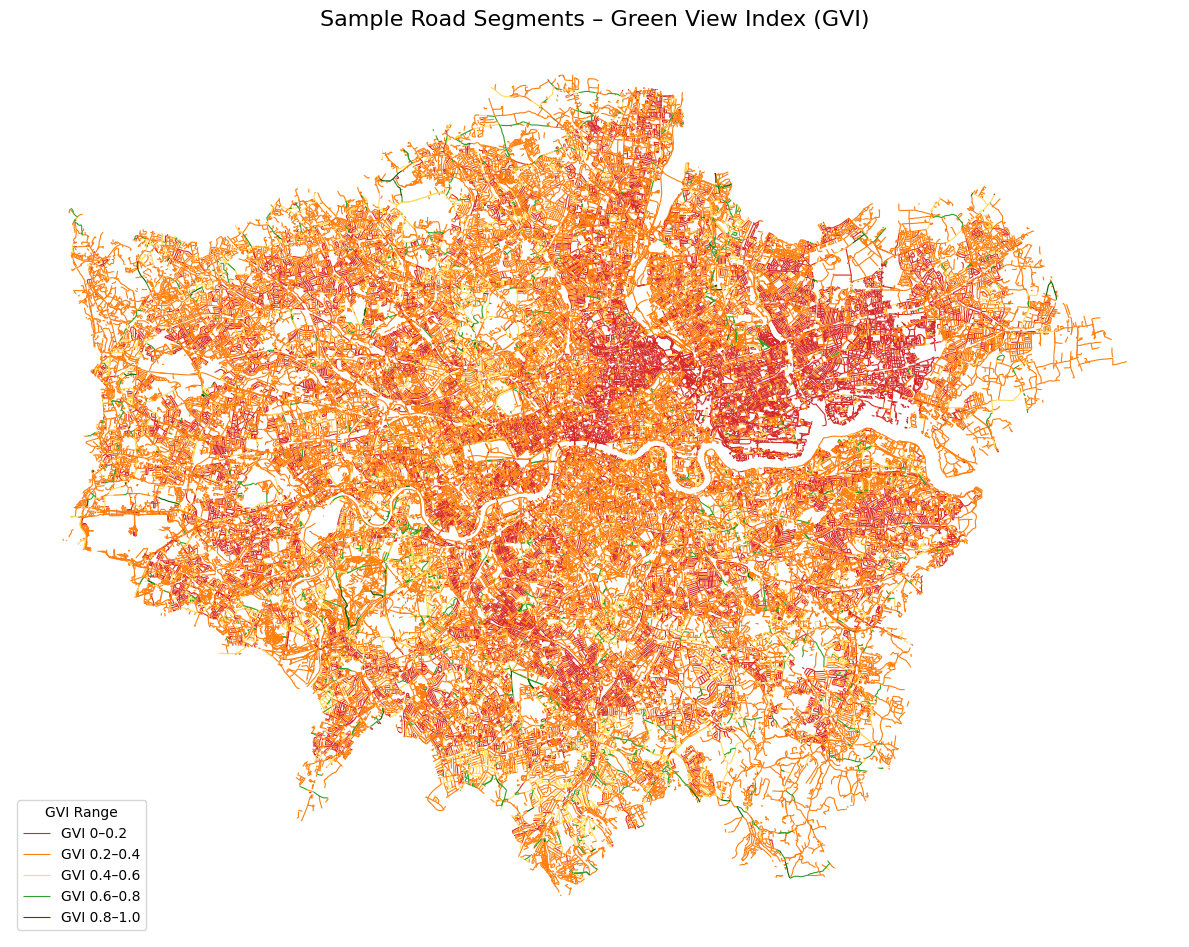

In [22]:
import matplotlib.pyplot as plt
import pandas as pd

# 自定义 GVI 分级颜色（从低到高）
gvi_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
gvi_colors = ['#d62728', '#ff7f0e', '#ffdb58', '#2ca02c', '#006400']
gvi_labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']

# 步骤 1：归一化
edges_final['gvi_final_norm'] = edges_final['gvi_final'] / edges_final['gvi_final'].max()

# 步骤 2：分组
edges_final['gvi_group'] = pd.cut(
    edges_final['gvi_final_norm'],
    bins=gvi_bins,
    labels=gvi_labels,
    include_lowest=True
)

# 步骤 3：绘图
fig, ax = plt.subplots(figsize=(12, 12))
for label, color in zip(gvi_labels, gvi_colors):
    subset = edges_final[edges_final['gvi_group'] == label]
    if not subset.empty:
        subset.plot(ax=ax, color=color, linewidth=0.8, label=f'GVI {label}')

# 美化图形
ax.set_title("Sample Road Segments – Green View Index (GVI)", fontsize=16)
ax.set_axis_off()
ax.legend(title="GVI Range", loc='lower left')
plt.tight_layout()
plt.show()

#备用一个
edges_copy = edges_final

<Axes: >

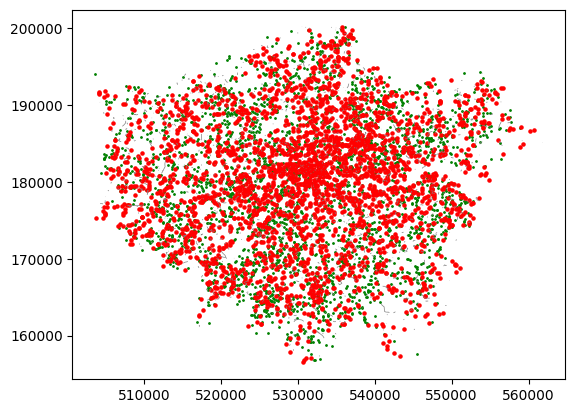

In [23]:
ax = edges_gdf.sample(3000).plot(color='gray', linewidth=0.5)
gvi_points.sample(3000).plot(ax=ax, color='green', markersize=1)
midpoints_gdf.sample(3000).plot(ax=ax, color='red', markersize=5)

### 然后做一下第二部分的AQI

In [25]:
# !pip install rasterstats
!pip install rasterio geopandas rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 619.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 49.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.8 MB/s eta 0:00:00


In [26]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import json

In [28]:
NO2 = '/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/NO2/AQI.tif'
with rasterio.open(NO2) as src:
    no2_array = src.read(1)
    meta = src.meta

print(no2_array.shape)
print(meta)

(2253, 2918)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 2918, 'height': 2253, 'count': 1, 'crs': CRS.from_wkt('PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","27700"]]'), 'transform': Affine(20.0, 0.0, 503590.0,
       0.0, -20.0, 200930.0)}


In [30]:
import numpy as np
import rasterio
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge

In [ ]:
print("沿线定距采样 NO₂ 平均值（spacing=10m）...")

edges_final = edges_final.to_crs('EPSG:27700').copy()
edges_final = edges_final[edges_final.geometry.notna()].copy()

def _to_linestring(geom):
    # 统一处理 MultiLineString
    if isinstance(geom, LineString):
        return geom
    if isinstance(geom, MultiLineString):
        try:
            return linemerge(geom)
        except Exception:
            # 退化为选最长那条
            parts = list(geom.geoms)
            parts.sort(key=lambda g: g.length, reverse=True)
            return parts[0]
    return geom  # 其他情况原样返回

def mean_no2_along_line(geom, src, spacing=10.0):
    g = _to_linestring(geom)
    if not isinstance(g, LineString) or g.length == 0:
        return np.nan
    # 生成定距采样点
    n = max(2, int(g.length // spacing) + 1)
    dists = np.linspace(0, g.length, n)
    xs = []; ys = []
    for d in dists:
        p = g.interpolate(d)
        xs.append(p.x); ys.append(p.y)
    # 栅格取样
    vals = np.array([v[0] for v in src.sample(zip(xs, ys))], dtype="float64")
    # 处理 nodata
    if src.nodata is not None:
        vals[vals == src.nodata] = np.nan
    return float(np.nanmean(vals)) if np.isfinite(vals).any() else np.nan

with rasterio.open(NO2) as src:
    edges_final["NO2_mean"] = edges_final.geometry.apply(lambda g: mean_no2_along_line(g, src, spacing=10.0))

print("完成：", edges_final["NO2_mean"].notna().sum(), "条有值")

🚀 沿线定距采样 NO₂ 平均值（spacing=10m）...
✅ 完成： 163993 条有值


In [32]:
# 查看值分布
print(edges_final['NO2_mean'].describe())

count    163993.000000
mean         22.397302
std           5.615441
min          12.870447
25%          18.658517
50%          21.176516
75%          24.838254
max          93.094032
Name: NO2_mean, dtype: float64


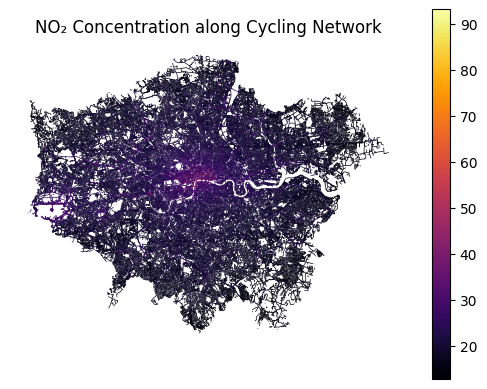

In [33]:
edges_final.plot(column='NO2_mean', cmap='inferno', linewidth=0.5, legend=True)
plt.title('NO₂ Concentration along Cycling Network')
plt.axis('off')
plt.show()

In [34]:
edges_final.to_file("/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/edges_gvi_no2.gpkg", driver="GPKG")

print("导出成功")

导出成功


### 嗯嗯做一下10

新版

In [35]:
from shapely.ops import nearest_points

In [36]:
# edges_final = gpd.read_file('/content/drive/MyDrive/CASA0004_Cycling/data/Env/export/edges_gvi_no2.gpkg')
natural = gpd.read_file('/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/nature_features/greater_london_nature_features.shp')

natural = natural.to_crs('EPSG:27700')
edges_final = edges_final.to_crs('EPSG:27700')

In [37]:
edges_final['natural_score'] = 0.0

In [38]:
# 设置 buffer 级别及对应得分（从远到近）===
buffer_levels = [
    (50, 0.1),
    (40, 0.2),
    (30, 0.3),
    (20, 0.5),
    (10, 0.7),
    (1, 1.0)
]

In [39]:
# === 4. 按层叠加 buffer，更新 natural_score ===
for radius, score in buffer_levels:
    print(f"🔄 处理 buffer {radius}m -> score {score}")
    buf_union = natural.buffer(radius).unary_union
    mask = edges_final.geometry.intersects(buf_union)
    edges_final.loc[mask, 'natural_score'] = score  # 更新得分

🔄 处理 buffer 50m -> score 0.1


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


🔄 处理 buffer 40m -> score 0.2


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


🔄 处理 buffer 30m -> score 0.3


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


🔄 处理 buffer 20m -> score 0.5


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


🔄 处理 buffer 10m -> score 0.7


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


🔄 处理 buffer 1m -> score 1.0


/tmp/ipython-input-3094134257.py:4: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  buf_union = natural.buffer(radius).unary_union


In [40]:
edges_final.to_file("/content/drive/MyDrive/CASA0004_Cycling/data/s2_Env/Export/edges_gvi_no2_nf.gpkg", driver="GPKG")

print("导出成功")

导出成功
